In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm, uniform
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange
from abc import ABC, abstractmethod
from shared.config_plt import config_plt, get_fig_ax, save_my_fig, colors
from shared.utils import print_se_parentheses, rank
from shared.univariate import DiscretizedDist, PriorAnalyzer, RankSumAnalyzer, RoundedAnalyzer, NeighborhoodAnalyzer, BRIOneSidedAnalyzer, BRIAsympAnalyzer, DiffMeansAnalyzer, LIBDiffMeansAnalyzer
config_plt()

In [2]:
theta_abs_lim = 50.
theta_min = -theta_abs_lim
theta_max = theta_abs_lim
theta_inc = 0.01
theta_vals = np.arange(theta_min, theta_max+0.0001, theta_inc)
n_theta_vals = theta_vals.size
alpha = 0.05
n_each = 5
n = 2*n_each
n_arange = np.arange(n)
exact = n_each <= 10
if exact:
    combs = list(combinations(range(n), n_each))
    n_combs = len(combs)
    n_combs_arange = np.arange(n_combs)
    a_vals = np.full((n_combs, n), False, dtype=bool)
    for i, c in enumerate(combs):
        a_vals[i, c] = True
        
def sample_a(rng):
    if exact:
        a_idx = rng.choice(n_combs_arange)    
        a_sample = a_vals[a_idx]
    else:
        a_idx = rng.choice(n_arange, n_each, replace=False)
        a_sample = np.isin(n_arange, a_idx)
    return a_sample

theta_rng = np.random.default_rng(seed=1)
prior_dist = DiscretizedDist(norm(loc=0., scale=10.), theta_vals, theta_rng)
prior_analyzer = PriorAnalyzer("Prior", alpha, prior_dist)
diff_mean_analyzer = DiffMeansAnalyzer("DIM", alpha, prior_dist)
lib_analyzer = LIBDiffMeansAnalyzer("LIB", alpha, prior_dist)
rounded_analyzer = RoundedAnalyzer("BRI-R", alpha, prior_dist, n_each, n_theta_vals, a_vals, 0)
rank_sum_analyzer = RankSumAnalyzer("BRI-RS", alpha, prior_dist, n_each, n_theta_vals, a_vals)
neighborhood_analyzer = NeighborhoodAnalyzer("BRI-N", alpha, prior_dist, n_each, n_theta_vals, a_vals, 0.5)
bri_onesided_analyzer = BRIOneSidedAnalyzer("BRI-O", alpha, prior_dist, n_each, n_theta_vals, a_vals, 1.)
bri_asymp_analyzer = BRIAsympAnalyzer("BRI-A", alpha, prior_dist)

methods = [
    prior_analyzer,
    diff_mean_analyzer,
    lib_analyzer,
    bri_onesided_analyzer,
    bri_asymp_analyzer,
    rounded_analyzer,
    neighborhood_analyzer,
    rank_sum_analyzer
]
method_names = [m.name for m in methods]
n_methods = len(methods)

./figures/discrete-stats-exact/theta-improbable


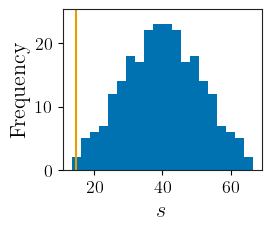

./figures/discrete-stats-exact/theta-probable


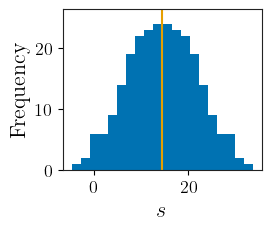

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


./figures/discrete-stats-exact/posteriors-dim


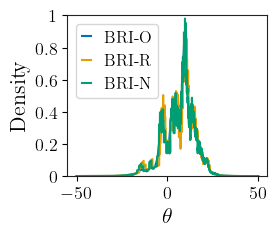

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


./figures/discrete-stats-exact/posteriors-rs


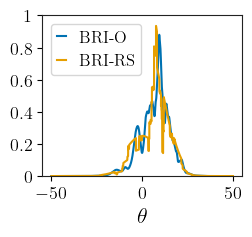

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


./figures/discrete-stats-exact/posteriors-asymp


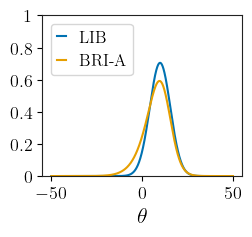

In [3]:
# Generate data
data_rng = np.random.default_rng(seed=2)
a_init = sample_a(data_rng)
not_a_init = ~a_init
y0_init = data_rng.normal(size=n, scale=10.) + data_rng.gamma(20./5., scale=5./2., size=n)
y1_init = y0_init + 10. + data_rng.normal(size=n, scale=10.)
ya_init = a_init*y1_init + not_a_init*y0_init
true_theta = 10.
y0 = ya_init - a_init*true_theta
y1 = y0 + true_theta
a = sample_a(data_rng)
not_a = ~a
y = a*y1 + not_a*y0

# Visualize data
figsize = (2.7, 2.2)
left_adjust = 0.22
bottom_adjust = 0.24
right_adjust = 0.96
top_adjust = 0.97
diff_means_observed, diff_means = neighborhood_analyzer.get_stats(y, a, theta_vals)

# Improbable theta
fig, ax = get_fig_ax(figsize=figsize)
theta_zero_idx = np.argmin(np.abs(theta_vals-40))
counts, _, _, = ax.hist(diff_means[theta_zero_idx], bins=20, color=colors[0], label="$p(s | \\theta=0, \\mathbf{y_a})$")
ax.axvline(diff_means_observed, color=colors[1], label="Observed")
ax.set_xlabel("$s$")
ax.set_ylabel("Frequency")
ax.set_ylim((0., np.max(counts)*1.1))
# plt.legend(loc="upper left")
plt.subplots_adjust(left_adjust, bottom_adjust, right_adjust, top_adjust)
save_my_fig(fig, "discrete-stats-exact/theta-improbable")
plt.show()

# Probable theta
fig, ax = get_fig_ax(figsize=figsize)
theta_zero_idx = np.argmin(np.abs(theta_vals-diff_means_observed))
counts, _, _, = ax.hist(diff_means[theta_zero_idx], bins=20, color=colors[0], label="$p(s | \\theta=1, \\mathbf{y_a})$")
ax.axvline(diff_means_observed, color=colors[1], label="Observed")
ax.set_xlabel("$s$")
ax.set_ylabel("Frequency")
ax.set_ylim((0., np.max(counts)*1.1))
plt.subplots_adjust(left_adjust, bottom_adjust, right_adjust, top_adjust)
save_my_fig(fig, "discrete-stats-exact/theta-probable")
plt.show()

# Posterior
fig, ax = get_fig_ax(figsize=figsize)
bri_onesided_probs = bri_onesided_analyzer.get_posterior_probs(y, a, theta_vals) / theta_inc
ax.plot(theta_vals, bri_onesided_probs, label=bri_onesided_analyzer.name)
rounded_probs = rounded_analyzer.get_posterior_probs(y, a, theta_vals) / theta_inc
ax.plot(theta_vals, rounded_probs, label=rounded_analyzer.name)
neighborhood_probs = neighborhood_analyzer.get_posterior_probs(y, a, theta_vals) / theta_inc
ax.plot(theta_vals, neighborhood_probs, label=neighborhood_analyzer.name)
ax.set_xlabel("$\\theta$")
ax.set_ylabel("Density")
y_ticks = np.array([0., 0.02, 0.04, 0.06, 0.08, 0.1])
y_max = np.max(y_ticks)
y_ticklabels = np.array(["0", "0.2", "0.4", "0.6", "0.8", "1"])
ax.set_ylim((0., y_max))
ax.set_yticks(y_ticks, y_ticklabels)
plt.legend(loc="upper left", fontsize=12, handlelength=0.5)
plt.subplots_adjust(left_adjust, bottom_adjust, right_adjust, top_adjust)
save_my_fig(fig, "discrete-stats-exact/posteriors-dim")
plt.show()

# Posterior
fig, ax = get_fig_ax(figsize=figsize)
ax.plot(theta_vals, bri_onesided_probs, label=bri_onesided_analyzer.name)
rank_sum_probs = rank_sum_analyzer.get_posterior_probs(y, a, theta_vals) / theta_inc
ax.plot(theta_vals, rank_sum_probs, label=rank_sum_analyzer.name)
ax.set_xlabel("$\\theta$")
ax.set_ylim((0., y_max))
ax.set_yticks(y_ticks, y_ticklabels)
plt.legend(loc="upper left", fontsize=12, handlelength=0.5)
plt.subplots_adjust(left_adjust, bottom_adjust, right_adjust, top_adjust)
save_my_fig(fig, "discrete-stats-exact/posteriors-rs")
plt.show()

# Posterior
fig, ax = get_fig_ax(figsize=figsize)
lib_probs = lib_analyzer.get_posterior_probs(y, a, theta_vals) / theta_inc
ax.plot(theta_vals, lib_probs, label=lib_analyzer.name)
bri_asymp_probs = bri_asymp_analyzer.get_posterior_probs(y, a, theta_vals) / theta_inc
ax.plot(theta_vals, bri_asymp_probs, label=bri_asymp_analyzer.name)
ax.set_xlabel("$\\theta$")
ax.set_ylim((0., y_max))
ax.set_yticks(y_ticks, y_ticklabels)
plt.legend(loc="upper left", fontsize=12, handlelength=0.5)
plt.subplots_adjust(left_adjust, bottom_adjust, right_adjust, top_adjust)
save_my_fig(fig, "discrete-stats-exact/posteriors-asymp")
plt.show()

In [4]:
# Simulation setup
n_reps = 1000
posterior_means = np.zeros((n_reps, n_methods))
lower_bounds = np.zeros((n_reps, n_methods))
upper_bounds = np.zeros((n_reps, n_methods))
nominal_coverage_rates = np.zeros((n_reps, n_methods))
true_thetas = np.zeros(n_reps)

# Simulation
for i in trange(n_reps):
    # Generate data
    a_init = sample_a(data_rng)
    not_a_init = ~a_init
    y0_init = data_rng.normal(size=n, scale=10.) + data_rng.gamma(20./5., scale=5./2., size=n)
    y1_init = y0_init + 10. + data_rng.normal(size=n, scale=10.)
    ya_init = a_init*y1_init + not_a_init*y0_init
    true_theta_i = prior_dist.rvs()
    y0 = ya_init - a_init*true_theta_i
    y1 = y0 + true_theta_i
    true_thetas[i] = true_theta_i
    a = sample_a(data_rng)
    not_a = ~a
    y = a*y1 + not_a*y0
    
    for j, method in enumerate(methods):
        # Get posterior probs
        pm, lb, ub, cr = method.analyze(y, a, theta_vals)
        posterior_means[i, j] = pm
        lower_bounds[i, j] = lb
        upper_bounds[i, j] = ub
        nominal_coverage_rates[i, j] = cr

100%|███████████████████████████████████████| 1000/1000 [10:39<00:00,  1.56it/s]


In [5]:
# Get mean and se
def get_mean_and_se(x, digits=2, stars=False, alpha=0.05):
    mean = x.mean(axis=0)
    se = x.std(axis=0) / np.sqrt(x.shape[0])
    mean_se = print_se_parentheses(mean, se, digits=digits, stars=stars, alpha=alpha)
    return mean_se

# Process results
errors = (posterior_means.T - true_thetas).T
errors2 = errors**2
ci_covered = ((lower_bounds.T <= true_thetas) & (true_thetas <= upper_bounds.T)).T
ci_length = upper_bounds - lower_bounds

arrs_to_process = [errors, errors2, ci_covered, nominal_coverage_rates, ci_length]
arrs_names_series = pd.Series(["Bias", "MSE", "CI Coverage", "CI Nominal Level", "CI Length"], name="Metrics")
method_names_series = pd.Series(method_names, name="Methods")

results_df = pd.DataFrame(
    np.stack([get_mean_and_se(arr) for arr in arrs_to_process]).T,
    index=method_names_series,
    columns=arrs_names_series)
results_df

Metrics,Bias,MSE,CI Coverage,CI Nominal Level,CI Length
Methods,,,,,
Prior,-0.18 (0.31),98.98 (4.27),0.96 (0.01),0.95 (0.00),39.21 (0.00)
DIM,-0.28 (0.30),91.42 (4.13),0.87 (0.01),0.95 (0.00),32.04 (0.29)
LIB,0.29 (0.23),54.49 (2.51),0.88 (0.01),0.95 (0.00),24.13 (0.13)
BRI-O,0.22 (0.24),58.11 (2.81),0.96 (0.01),0.95 (0.00),31.20 (0.13)
BRI-A,0.23 (0.23),54.62 (2.58),0.95 (0.01),0.95 (0.00),29.52 (0.13)
BRI-R,0.18 (0.25),61.41 (2.99),0.96 (0.01),0.95 (0.00),32.59 (0.13)
BRI-N,0.18 (0.25),61.40 (2.99),0.96 (0.01),0.95 (0.00),32.58 (0.13)
BRI-RS,0.35 (0.24),56.72 (2.70),0.97 (0.01),0.95 (0.00),33.04 (0.13)


In [6]:
print(results_df.to_latex())

\begin{tabular}{llllll}
\toprule
Metrics & Bias & MSE & CI Coverage & CI Nominal Level & CI Length \\
Methods &  &  &  &  &  \\
\midrule
Prior & -0.18 (0.31) & 98.98 (4.27) & 0.96 (0.01) & 0.95 (0.00) & 39.21 (0.00) \\
DIM & -0.28 (0.30) & 91.42 (4.13) & 0.87 (0.01) & 0.95 (0.00) & 32.04 (0.29) \\
LIB & 0.29 (0.23) & 54.49 (2.51) & 0.88 (0.01) & 0.95 (0.00) & 24.13 (0.13) \\
BRI-O & 0.22 (0.24) & 58.11 (2.81) & 0.96 (0.01) & 0.95 (0.00) & 31.20 (0.13) \\
BRI-A & 0.23 (0.23) & 54.62 (2.58) & 0.95 (0.01) & 0.95 (0.00) & 29.52 (0.13) \\
BRI-R & 0.18 (0.25) & 61.41 (2.99) & 0.96 (0.01) & 0.95 (0.00) & 32.59 (0.13) \\
BRI-N & 0.18 (0.25) & 61.40 (2.99) & 0.96 (0.01) & 0.95 (0.00) & 32.58 (0.13) \\
BRI-RS & 0.35 (0.24) & 56.72 (2.70) & 0.97 (0.01) & 0.95 (0.00) & 33.04 (0.13) \\
\bottomrule
\end{tabular}



In [7]:
def get_pairwise_comparisons(x):
    results = np.full((n_methods, n_methods), "-", dtype="object")
    for i, method_name in enumerate(method_names):
        x_i = x[:, i]
        for j, method_name in enumerate(method_names):
            x_j = x[:, j]
            if i != j:
                results[i, j] = get_mean_and_se(x_i - x_j, stars=True, alpha=alpha)[0]
    return results

pairwise_df = pd.DataFrame(
    np.vstack([
        get_pairwise_comparisons(errors),
        get_pairwise_comparisons(errors2),
        get_pairwise_comparisons(ci_covered.astype(float)),
        get_pairwise_comparisons(nominal_coverage_rates),
        get_pairwise_comparisons(ci_length)]),
    index=pd.MultiIndex.from_product([arrs_names_series, method_names_series]),
    columns=method_names_series)
pairwise_df

/Users/eastonhuch/Documents/research/bayesian-randomization-inference/shared/utils.py:17: RuntimeWarning: divide by zero encountered in scalar divide
  stars_chars = [("*" if abs(x[i]/x_ses[i]) >= z_star else "") for i in range(x.size)]


Methods                            Prior             DIM            LIB  \
Metrics          Methods                                                  
Bias             Prior                 -     0.10 (0.43)   -0.47 (0.26)   
                 DIM        -0.10 (0.43)               -  -0.57 (0.19)*   
                 LIB         0.47 (0.26)    0.57 (0.19)*              -   
                 BRI-O      0.41 (0.16)*     0.51 (0.29)   -0.06 (0.11)   
                 BRI-A      0.41 (0.19)*     0.51 (0.26)   -0.06 (0.08)   
                 BRI-R      0.36 (0.14)*     0.46 (0.31)   -0.11 (0.14)   
                 BRI-N      0.36 (0.14)*     0.46 (0.31)   -0.10 (0.14)   
                 BRI-RS     0.53 (0.20)*    0.63 (0.26)*    0.06 (0.09)   
MSE              Prior                 -     7.56 (5.67)  44.49 (3.83)*   
                 DIM        -7.56 (5.67)               -  36.93 (3.26)*   
                 LIB      -44.49 (3.83)*  -36.93 (3.26)*              -   
                 BRI-O    -40.87 (2.53)*  -33.31 (4.04)*   3.62 (1.64)*   
                 BRI-A    -44.36 (2.97)*  -36.80 (3.79)*    0.13 (1.14)   
                 BRI-R    -37.58 (2.20)*  -30.02 (4.22)*   6.91 (2.00)*   
                 BRI-N    -37.58 (2.20)*  -30.02 (4.22)*   6.91 (2.00)*   
                 BRI-RS   -42.26 (3.13)*  -34.70 (3.86)*    2.23 (1.35)   
CI Coverage      Prior                 -    0.09 (0.01)*   0.08 (0.01)*   
                 DIM       -0.09 (0.01)*               -   -0.01 (0.01)   
                 LIB       -0.08 (0.01)*     0.01 (0.01)              -   
                 BRI-O       0.00 (0.01)    0.09 (0.01)*   0.08 (0.01)*   
                 BRI-A      -0.00 (0.01)    0.08 (0.01)*   0.07 (0.01)*   
                 BRI-R       0.00 (0.01)    0.09 (0.01)*   0.08 (0.01)*   
                 BRI-N       0.00 (0.01)    0.09 (0.01)*   0.08 (0.01)*   
                 BRI-RS      0.01 (0.01)    0.10 (0.01)*   0.09 (0.01)*   
CI Nominal Level Prior                 -    0.00 (0.00)*  -0.00 (0.00)*   
                 DIM       -0.00 (0.00)*               -  -0.00 (0.00)*   
                 LIB        0.00 (0.00)*    0.00 (0.00)*              -   
                 BRI-O      0.00 (0.00)*    0.00 (0.00)*  -0.00 (0.00)*   
                 BRI-A      0.00 (0.00)*    0.00 (0.00)*  -0.00 (0.00)*   
                 BRI-R      0.00 (0.00)*    0.00 (0.00)*  -0.00 (0.00)*   
                 BRI-N      0.00 (0.00)*    0.00 (0.00)*  -0.00 (0.00)*   
                 BRI-RS     0.00 (0.00)*    0.00 (0.00)*  -0.00 (0.00)*   
CI Length        Prior                 -    7.17 (0.29)*  15.08 (0.13)*   
                 DIM       -7.17 (0.29)*               -   7.92 (0.16)*   
                 LIB      -15.08 (0.13)*   -7.92 (0.16)*              -   
                 BRI-O     -8.01 (0.13)*   -0.84 (0.24)*   7.07 (0.13)*   
                 BRI-A     -9.69 (0.13)*   -2.52 (0.23)*   5.39 (0.11)*   
                 BRI-R     -6.62 (0.13)*    0.55 (0.26)*   8.46 (0.14)*   
                 BRI-N     -6.63 (0.13)*    0.53 (0.26)*   8.45 (0.14)*   
                 BRI-RS    -6.17 (0.13)*    1.00 (0.24)*   8.92 (0.12)*   

Methods                           BRI-O          BRI-A          BRI-R  \
Metrics          Methods                                                
Bias             Prior    -0.41 (0.16)*  -0.41 (0.19)*  -0.36 (0.14)*   
                 DIM       -0.51 (0.29)   -0.51 (0.26)   -0.46 (0.31)   
                 LIB        0.06 (0.11)    0.06 (0.08)    0.11 (0.14)   
                 BRI-O                -   -0.00 (0.03)    0.04 (0.03)   
                 BRI-A      0.00 (0.03)              -    0.05 (0.06)   
                 BRI-R     -0.04 (0.03)   -0.05 (0.06)              -   
                 BRI-N     -0.04 (0.02)   -0.05 (0.06)    0.00 (0.00)   
                 BRI-RS    0.12 (0.06)*   0.12 (0.05)*   0.17 (0.08)*   
MSE              Prior    40.87 (2.53)*  44.36 (2.97)*  37.58 (2.20)*   
                 DIM      33.31 (4.04)*  36.80